In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pywt
import librosa
import librosa.display
from librosa.filters import mel

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import random
from random import seed, random, randint, sample
from scipy.signal import hilbert, chirp
from scipy.io import wavfile
from tqdm import tqdm

%matplotlib inline

In [2]:
# using speech data
speech_folder_name = './Audio_Speech_Actors_01-24/'
actors_folder_name = [os.path.join(speech_folder_name, actor) for actor in os.listdir(speech_folder_name)]
audio_files_path = [os.path.join(actor_num, file) for actor_num in actors_folder_name for file in os.listdir(actor_num)]
data = np.array([[file_path, int(file_path.split('\\')[-1].split('-')[2])-1] for file_path in audio_files_path])

labels = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
print(f"{len(audio_files_path)} Audio files fetched...\n")
labels_idx, count = np.unique(data[:, -1], return_counts=True)
for i in range(len(count)):
    print(f"{labels[int(labels_idx[i])]} -> {count[i]} samples.")


1440 Audio files fetched...

neutral -> 96 samples.
calm -> 192 samples.
happy -> 192 samples.
sad -> 192 samples.
angry -> 192 samples.
fearful -> 192 samples.
disgust -> 192 samples.
surprised -> 192 samples.


In [3]:
#reading random audio file
sr=16000 #16KHz
rand_audio_file = audio_files_path[randint(0, len(audio_files_path))]
seq, sr = librosa.load(rand_audio_file, sr=sr)
print(f"Audio file: {seq.shape}\nSamplirng rate: {sr}")
print(rand_audio_file)

Audio file: (65132,)
Samplirng rate: 16000
./Audio_Speech_Actors_01-24/Actor_21\03-01-07-02-01-01-21.wav


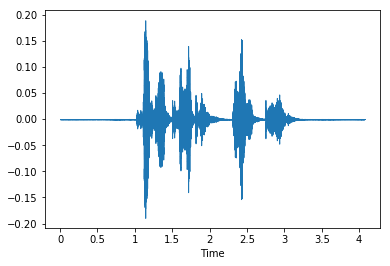

In [4]:
librosa.display.waveshow(seq, sr=sr)

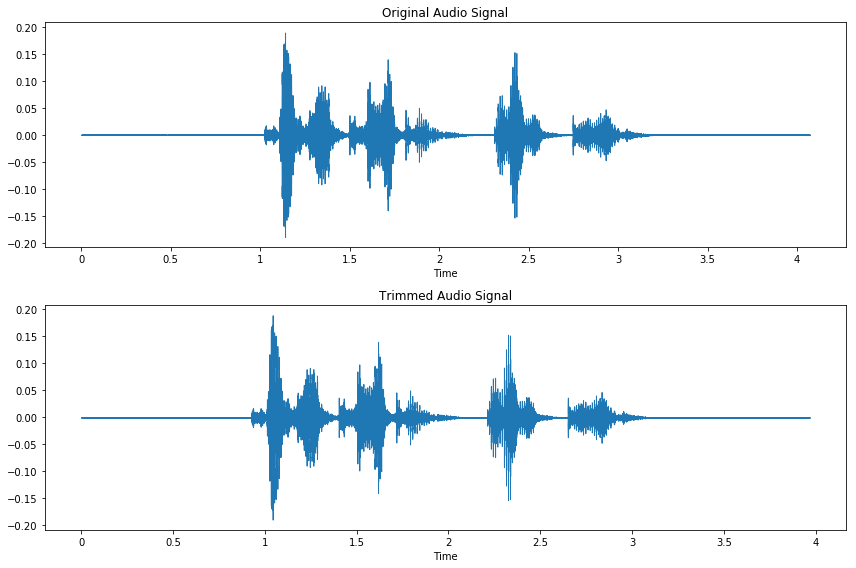

Original: 2.9538321995464853
Trimmed: 2.8792743764172335


In [5]:
# Trimming Leading and Trailing silence
trimmed_audio, index = librosa.effects.trim(seq)

# Visualize the original and trimmed signals
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(seq, sr=sr)
plt.title('Original Audio Signal')

plt.subplot(2, 1, 2)
librosa.display.waveshow(trimmed_audio, sr=sr)
plt.title('Trimmed Audio Signal')

plt.tight_layout()
plt.show()

print(f"Original: {librosa.get_duration(y=seq)}\nTrimmed: {librosa.get_duration(y=trimmed_audio)}")

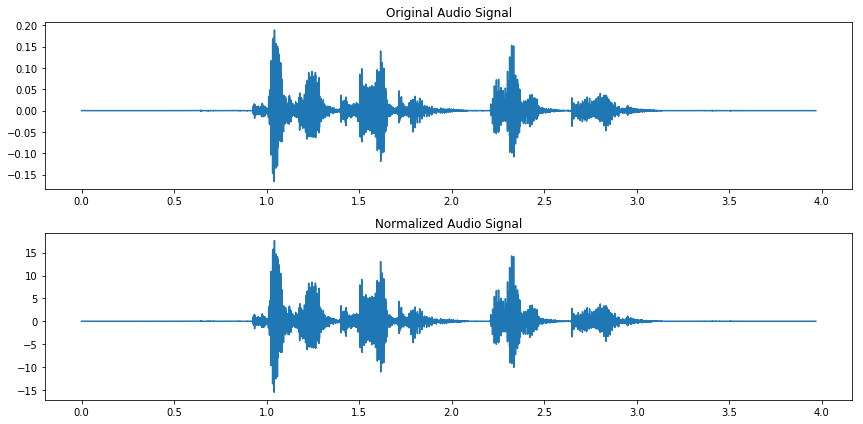

Audio Before -> mean=6.513181460832129e-07, std=0.010719433426856995
Audio After -> mean=-1.0007962236713297e-09, std=0.9999999403953552


In [6]:
# Audio Normalization - mean is 0 and std is 1
norm_seq = trimmed_audio.reshape(-1, 1)
scaler = StandardScaler()
norm_seq = (trimmed_audio - np.mean(trimmed_audio))/np.std(trimmed_audio)



time = np.arange(0, len(norm_seq)) / sr

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, trimmed_audio)
plt.title('Original Audio Signal')

plt.subplot(2, 1, 2)
plt.plot(time, norm_seq)
plt.title('Normalized Audio Signal')

plt.tight_layout()
plt.show()

print(f"Audio Before -> mean={np.mean(trimmed_audio)}, std={np.std(trimmed_audio)}")
print(f"Audio After -> mean={np.mean(norm_seq)}, std={np.std(norm_seq)}")

In [7]:
wavfile.write('norm.wav', sr, norm_seq)
wavfile.write('trim.wav', sr, trimmed_audio)

In [8]:
# Data Augmentation
def add_awgn(audio):
    snr_db = np.random.uniform(15, 30)
    noise_std = np.sqrt(np.var(audio) / (10 ** (snr_db / 10)))
    gaussian_noise = np.random.normal(0, noise_std, len(audio))
    return audio + gaussian_noise

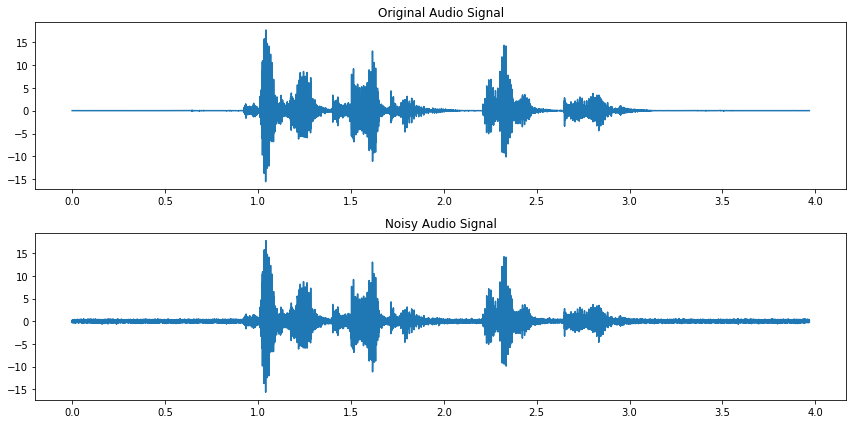

In [9]:
noisy = add_awgn(norm_seq)

time = np.arange(0, len(noisy)) / sr

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, norm_seq)
plt.title('Original Audio Signal')

plt.subplot(2, 1, 2)
plt.plot(time, noisy)
plt.title(f'Noisy Audio Signal')

plt.tight_layout()
plt.show()

In [10]:
wavfile.write('test.wav', sr, noisy)

In [11]:
from scipy import signal

In [13]:
# Continous Wavelet transform implementation
wavelet='morl'
sr = 16000
widths = np.arange(1, 256)
#print(f"Scales using: {widths}")

dt = 1/sr
frequencies = pywt.scale2frequency(wavelet=wavelet, scale=widths) / dt
#print(f"Frequencies associated with the scales: {frequencies}")

#creating filter to select frequencies between 20Hz and 5Khz - this is where most speech lies
upper = [x for x in range(len(widths)) if frequencies[x] > 2000][-1]
lower = [x for x in range(len(widths)) if frequencies[x] < 80][0]

widths = widths[upper:lower]

#computing wavelet transform 
wavelet_coefs, freqs = pywt.cwt(norm_seq, widths, wavelet=wavelet, sampling_period=dt)
print(f"shape of wavelet transform: {wavelet_coefs.shape}")

shape of wavelet transform: (157, 63488)


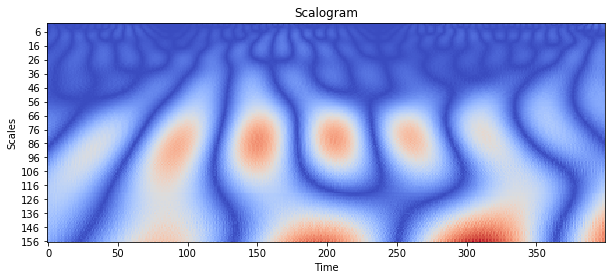

In [14]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(wavelet_coefs[:,:400]), cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Scales')
plt.yticks(widths[0::10])
plt.title('Scalogram')
plt.show()

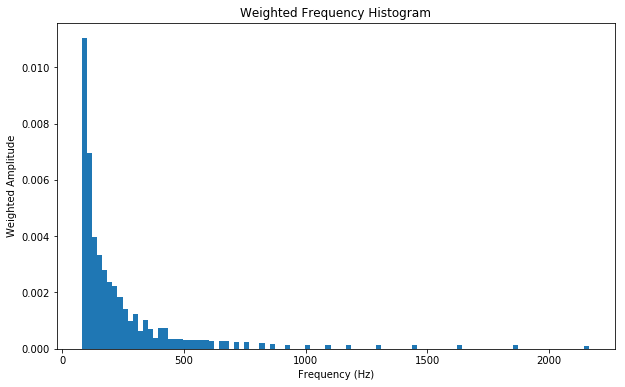

In [15]:
amplitudes = np.abs(wavelet_coefs)
weighted_frequencies = np.sum(amplitudes, axis=1)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(freqs, bins=100,weights=weighted_frequencies, density=True)
plt.title('Weighted Frequency Histogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Weighted Amplitude')
plt.show()

In [15]:
"""
TO DO LIST
[] Visualize Spectogram for all emotions 
[] visualize frequency wieghted histogram for male vs female 
"""

'\nTO DO LIST\n[] Visualize Spectogram for all emotions \n[] visualize frequency wieghted histogram for male vs female \n'

In [16]:
# Fixed Segment Generation
start = 0
end = wavelet_coefs.shape[1]
frames = []
frame_size = 400
count = 0

while start + frame_size <= end -1:
    f = (wavelet_coefs)[:, start:start+frame_size]
    assert f.shape[1] == frame_size
    frames.append(f)
    start += frame_size

frames = np.array(frames)
frames = frames.reshape((len(frames), wavelet_coefs.shape[0], frame_size))

print(frames.shape)


(158, 157, 400)


In [ ]:
def compute_wavelet(audio):
    

In [ ]:
# Generate Training Data
